# Natural Language Processing Final Project

## MLP Models

**Joana Rio Maior - 176189**

**Johanna Langemeyer - 175861**

**Maïwenn Mignon - 176196**

In this notebook, we implement two MLP Models focused on New York Times articles section classification. Due to the use of different Numpy Libraries, the MLP models were extracted to a separate notebook. Test and Train split as well as evaluation was kept coherent to the other models.

### Libraries

In [1]:
!pip install --quiet torch==2.6.0 torchvision==0.21.0+cu124 torchaudio==2.6.0+cu124 \
    --extra-index-url https://download.pytorch.org/whl/cu124
!pip install --quiet gensim scikit-learn nltk

# If installations show an error, reset runtime and run again

In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

import numpy as np
import pandas as pd
import gensim.downloader as api
import torch
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, log_loss
)

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score, f1_score
import seaborn as sns

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

print("All packages installed and imported successfully!")

All packages installed and imported successfully!


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Loading Dataset

In [5]:
sampled_df=pd.read_csv('https://www.dropbox.com/scl/fi/hzvssw1v0lhqbnnemnjuf/sampled_df_export.csv?rlkey=t71ndwe7qa9t3mh2uwxnttomv&dl=1')

In [8]:
sampled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140000 entries, 0 to 139999
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   abstract        140000 non-null  object 
 1   lead_paragraph  140000 non-null  object 
 2   headline        139974 non-null  object 
 3   section_name    140000 non-null  object 
 4   word_count      140000 non-null  float64
 5   year            140000 non-null  int64  
 6   month           140000 non-null  int64  
 7   text_raw        140000 non-null  object 
 8   text_clean      140000 non-null  object 
 9   neg             140000 non-null  float64
 10  neu             140000 non-null  float64
 11  pos             140000 non-null  float64
 12  compound        140000 non-null  float64
 13  label           140000 non-null  int64  
dtypes: float64(5), int64(3), object(6)
memory usage: 15.0+ MB


### Basic MLP

In [9]:
# Encode the section_name column into numerical labels
label_encoder = LabelEncoder()
sampled_df['label'] = label_encoder.fit_transform(sampled_df['section_name'])

In [10]:
# Average pooling function

def average_embedding_MLP(text, wv_model):
    tokens = text.split()  # simple whitespace tokenize
    vecs = [wv_model[t] for t in tokens if t in wv_model]
    if not vecs:
        return np.zeros(wv_model.vector_size, dtype=np.float32)
    return np.mean(vecs, axis=0).astype(np.float32)

# For each token present in Word2Vec, grabs its 300 dim Vector
# For empty cases, returns zero vector
# Mean pooling across all tokens vectors to get one article-level embedding

In [12]:
temp_df_MLP, test_df_MLP = train_test_split(sampled_df, test_size=0.15, stratify=sampled_df['label'], random_state=42)
val_frac_MLP = 0.15/0.85
train_df_MLP, val_df_MLP = train_test_split(temp_df_MLP, test_size=val_frac_MLP, stratify=temp_df_MLP['label'], random_state=42)


# splitting into 70/15/15

In [14]:

wv = api.load("word2vec-google-news-300")
# Look up table of words to 300 dim vectors

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [15]:
# Feature Matrics

X_train_MLP = np.vstack(train_df_MLP['text_clean'].apply(lambda t: average_embedding_MLP(t, wv)))
y_train_MLP = train_df_MLP['label'].values
X_val_MLP   = np.vstack(val_df_MLP['text_clean'].apply(lambda t: average_embedding_MLP(t, wv)))
y_val_MLP   = val_df_MLP['label'].values
X_test_MLP  = np.vstack(test_df_MLP['text_clean'].apply(lambda t: average_embedding_MLP(t, wv)))
y_test_MLP  = test_df_MLP['label'].values

# Stacks each 300-dim result into an array

In [17]:
# Data set and data loader

class SectionDatasetMLP(Dataset):
    def __init__(self, embeddings, labels):
        self.X = torch.from_numpy(embeddings).float()
        self.y = torch.tensor(labels, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader_MLP = DataLoader(SectionDatasetMLP(X_train_MLP, y_train_MLP), batch_size=64, shuffle=True)
val_loader_MLP   = DataLoader(SectionDatasetMLP(X_val_MLP,   y_val_MLP),   batch_size=64, shuffle=False)
test_loader_MLP  = DataLoader(SectionDatasetMLP(X_test_MLP,  y_test_MLP),  batch_size=64, shuffle=False)

# Dataset wraps numpy arrays into pytoch friendly interface
# DataLoader handles batching and shuffling
# Shuffling only on train to present data in new order each epoch to improve generalization
# Batch size: number of training examples model processes before updating weights

In [18]:
class SectionMLP(nn.Module):
    def __init__(self, input_dim=300, hidden_dim=256,
                 num_classes=15, dropout=0.3):
        super().__init__()
        # first linear layer: projects 300 → 256 dimensions
        self.fc1  = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()            # non-linearity
        self.drop = nn.Dropout(dropout)  # regularization
        # output layer: 256 → num_classes logits
        self.fc2  = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.fc1(x)    # dense projection
        x = self.relu(x)   # add non-linearity
        x = self.drop(x)   # randomly zero some activations
        x = self.fc2(x)    # final unnormalized score for each section
        return x

In [20]:
class Trainer_MLP:
    def __init__(self, model, train_loader_MLP, val_loader_MLP, device, patience=5):
        self.model           = model.to(device)
        self.train_loader_MLP = train_loader_MLP
        self.val_loader_MLP   = val_loader_MLP
        self.device          = device
        self.criterion       = nn.CrossEntropyLoss()
        self.optimizer       = optim.AdamW(model.parameters(), lr=1e-3)
        self.patience        = patience

    def train(self, epochs=20):
        best_f1       = 0.0
        epochs_no_imp = 0
        best_weights  = None

        for epoch in range(1, epochs + 1):
            # Training phase
            self.model.train()
            total_loss = 0.0
            for Xb, yb in self.train_loader_MLP:
                Xb, yb = Xb.to(self.device), yb.to(self.device)
                self.optimizer.zero_grad()
                logits = self.model(Xb)
                loss   = self.criterion(logits, yb)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item() * Xb.size(0)
            avg_loss = total_loss / len(self.train_loader_MLP.dataset)

            # Evaluation phase
            train_acc, train_f1, train_prec, train_rec = self.evaluate_MLP(self.train_loader_MLP)
            val_acc,   val_f1,   val_prec,   val_rec   = self.evaluate_MLP(self.val_loader_MLP)

            print(
                f"Epoch {epoch:02d} | Loss: {avg_loss:.4f} "
                f"| Train → Acc: {train_acc:.4f}, F1: {train_f1:.4f}, "
                f"Prec: {train_prec:.4f}, Rec: {train_rec:.4f} "
                f"| Val → Acc: {val_acc:.4f}, F1: {val_f1:.4f}, "
                f"Prec: {val_prec:.4f}, Rec: {val_rec:.4f}"
            )

            # Early-stopping check on validation F1
            if val_f1 > best_f1:
                best_f1       = val_f1
                epochs_no_imp = 0
                best_weights  = {k: v.cpu() for k, v in self.model.state_dict().items()}
            else:
                epochs_no_imp += 1
                if epochs_no_imp >= self.patience:
                    print(f"No improvement for {self.patience} epochs (best Val F1={best_f1:.4f}). Stopping early.")
                    break

        # Restore best weights
        if best_weights is not None:
            self.model.load_state_dict(best_weights)
            print(f"Restored model weights from epoch {epoch - epochs_no_imp} (Val F1={best_f1:.4f})")

    def evaluate_MLP(self, loader):
        self.model.eval()
        preds, truths = [], []
        with torch.no_grad():
            for Xb, yb in loader:
                Xb = Xb.to(self.device)
                logits = self.model(Xb)
                batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
                preds.extend(batch_preds)
                truths.extend(yb.numpy())

        acc     = accuracy_score(truths, preds)
        macro_f1= f1_score(truths, preds, average='macro')
        macro_prec = precision_score(truths, preds, average='macro', zero_division=0)
        macro_rec  = recall_score(truths, preds, average='macro', zero_division=0)

        return acc, macro_f1, macro_prec, macro_rec

    def test_MLP(self, test_loader_MLP):
        acc, macro_f1, macro_prec, macro_rec = self.evaluate_MLP(test_loader_MLP)
        print(
            f"Test → Acc: {acc:.4f}, F1: {macro_f1:.4f}, "
            f"Prec: {macro_prec:.4f}, Rec: {macro_rec:.4f}"
        )

In [21]:
# Run Pipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_MLP = SectionMLP(input_dim=300, hidden_dim=256, num_classes=14, dropout = 0.3)
trainer_MLP = Trainer_MLP(model_MLP, train_loader_MLP, val_loader_MLP, device)
trainer_MLP.train(epochs=30)
trainer_MLP.test_MLP(test_loader_MLP)

Epoch 01 | Loss: 1.1843 | Train → Acc: 0.7114, F1: 0.7076, Prec: 0.7077, Rec: 0.7114 | Val → Acc: 0.7121, F1: 0.7086, Prec: 0.7086, Rec: 0.7121
Epoch 02 | Loss: 0.9371 | Train → Acc: 0.7260, F1: 0.7236, Prec: 0.7242, Rec: 0.7260 | Val → Acc: 0.7256, F1: 0.7233, Prec: 0.7241, Rec: 0.7256
Epoch 03 | Loss: 0.8927 | Train → Acc: 0.7334, F1: 0.7306, Prec: 0.7319, Rec: 0.7334 | Val → Acc: 0.7287, F1: 0.7263, Prec: 0.7277, Rec: 0.7287
Epoch 04 | Loss: 0.8632 | Train → Acc: 0.7390, F1: 0.7358, Prec: 0.7392, Rec: 0.7390 | Val → Acc: 0.7348, F1: 0.7316, Prec: 0.7345, Rec: 0.7348
Epoch 05 | Loss: 0.8412 | Train → Acc: 0.7453, F1: 0.7426, Prec: 0.7440, Rec: 0.7453 | Val → Acc: 0.7361, F1: 0.7335, Prec: 0.7345, Rec: 0.7361
Epoch 06 | Loss: 0.8247 | Train → Acc: 0.7493, F1: 0.7457, Prec: 0.7501, Rec: 0.7493 | Val → Acc: 0.7410, F1: 0.7372, Prec: 0.7417, Rec: 0.7410
Epoch 07 | Loss: 0.8088 | Train → Acc: 0.7553, F1: 0.7525, Prec: 0.7540, Rec: 0.7553 | Val → Acc: 0.7440, F1: 0.7411, Prec: 0.7423, Rec:

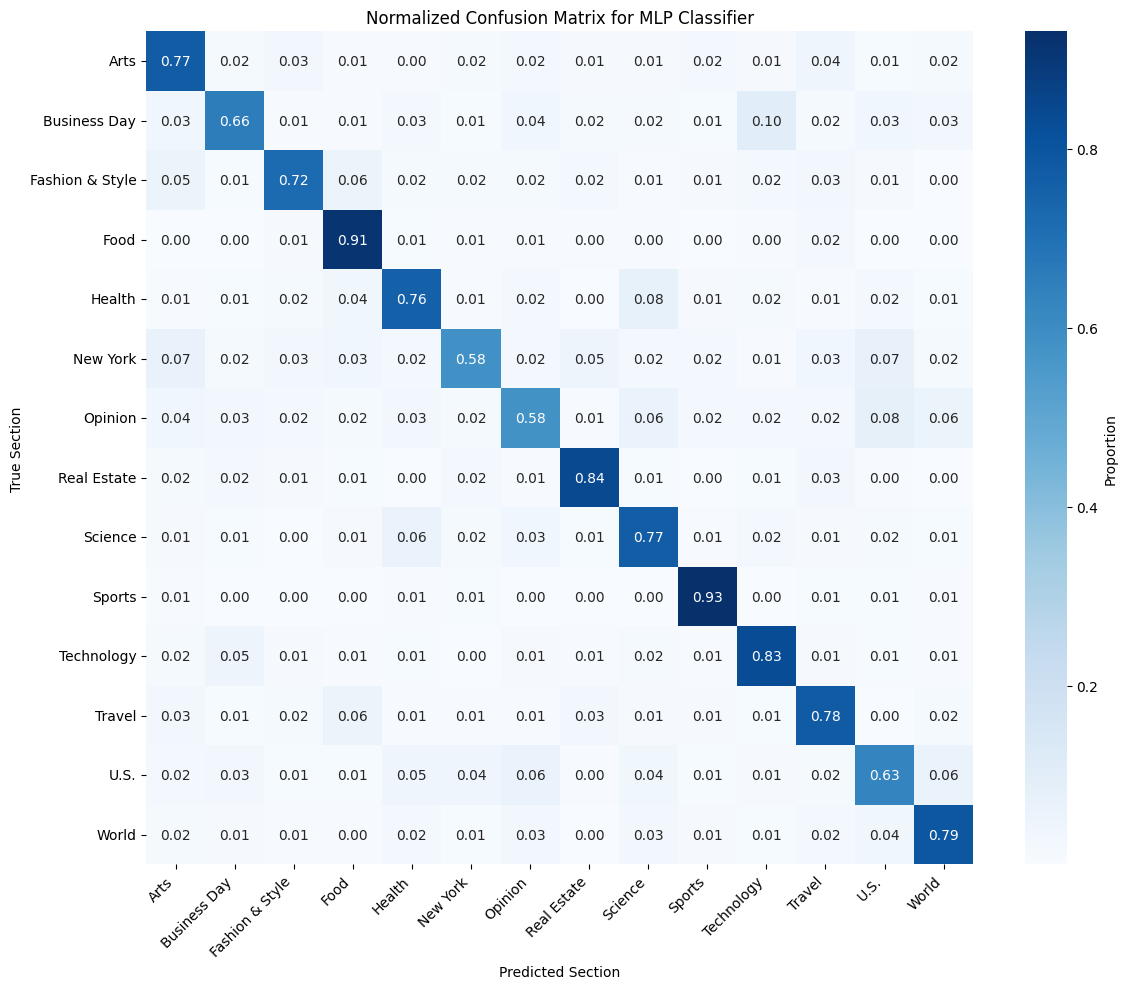

In [22]:

# Collect true & predicted labels on the test set
model_MLP.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for Xb, yb in test_loader_MLP:
        Xb = Xb.to(device)
        logits = model_MLP(Xb)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(yb.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute confusion matrix (raw and normalized)
labels = list(range(len(label_encoder.classes_)))  # e.g. [0,1,…,14]
cm     = confusion_matrix(y_true, y_pred, labels=labels)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

# Visualize normalized confusion matrix
section_names = label_encoder.inverse_transform(labels)

plt.figure(figsize=(12,10))
sns.heatmap(
    cm_norm,
    xticklabels=section_names,
    yticklabels=section_names,
    cmap="Blues",
    annot=True,
    fmt=".2f",
    cbar_kws={"label":"Proportion"}
)
plt.xlabel("Predicted Section")
plt.ylabel("True Section")
plt.title("Normalized Confusion Matrix for MLP Classifier")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### MLP with Sentiment

In [23]:
# get 300-d embeddings
E_train_MLPS = np.vstack(train_df_MLP['text_clean'].apply(lambda t: average_embedding_MLP(t, wv)))
# extract sentiment as (n_train,1)
S_train_MLPS = train_df_MLP[['neg', 'neu', 'pos', 'compound']].to_numpy(dtype=np.float32)
# concatenate → (n_train, 301)
X_train_MLPS = np.hstack([E_train_MLPS, S_train_MLPS])

# validation
E_val_MLPS   = np.vstack(val_df_MLP['text_clean'].apply(lambda t: average_embedding_MLP(t, wv)))
S_val_MLPS   = val_df_MLP[['neg', 'neu', 'pos', 'compound']].to_numpy(dtype=np.float32)
X_val_MLPS   = np.hstack([E_val_MLPS, S_val_MLPS])

# test
E_test_MLPS  = np.vstack(test_df_MLP['text_clean'].apply(lambda t: average_embedding_MLP(t, wv)))
S_test_MLPS  = test_df_MLP[['neg', 'neu', 'pos', 'compound']].to_numpy(dtype=np.float32)
X_test_MLPS  = np.hstack([E_test_MLPS, S_test_MLPS])


# Scale all 304 dims based on the training split
scaler = StandardScaler().fit(X_train_MLPS)
X_train_MLPS = scaler.transform(X_train_MLPS)
X_val_MLPS   = scaler.transform(X_val_MLPS)
X_test_MLPS  = scaler.transform(X_test_MLPS)

# extract labels and proceed to Dataset/DataLoader
y_train_MLPS = train_df_MLP['label'].to_numpy()
y_val_MLPS   = val_df_MLP['label'].to_numpy()
y_test_MLPS  = test_df_MLP['label'].to_numpy()

In [24]:
class SectionDatasetMLPS(Dataset):
    def __init__(self, embeddings, labels):
        self.X = torch.from_numpy(embeddings).float()
        self.y = torch.tensor(labels, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader_MLPS = DataLoader(SectionDatasetMLPS(X_train_MLPS, y_train_MLPS), batch_size=64, shuffle=True)
val_loader_MLPS   = DataLoader(SectionDatasetMLPS(X_val_MLPS,   y_val_MLPS),   batch_size=64, shuffle=False)
test_loader_MLPS  = DataLoader(SectionDatasetMLPS(X_test_MLPS,  y_test_MLPS),  batch_size=64, shuffle=False)

# Dataset wraps numpy arrays into pytoch friendly interface
# DataLoader handles batching and shuffling
# Shuffling only on train to present data in new order each epoch to improve generalization
# Batch size: number of training examples model processes before updating weights

In [25]:
class SectionMLPS(nn.Module):
    def __init__(self, input_dim=304, hidden_dim=256,
                 num_classes=15, dropout=0.3):
        super().__init__()
        # first linear layer: projects 300 → 256 dimensions
        self.fc1  = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()            # non-linearity
        self.drop = nn.Dropout(dropout)  # regularization
        # output layer: 256 → num_classes logits
        self.fc2  = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.fc1(x)    # dense projection
        x = self.relu(x)   # add non-linearity
        x = self.drop(x)   # randomly zero some activations
        x = self.fc2(x)    # final unnormalized score for each section
        return x

In [26]:
class Trainer_MLPS:
    def __init__(self, model, train_loader_MLPS, val_loader_MLPS, device, patience=5):
        self.model             = model.to(device)
        self.train_loader_MLPS = train_loader_MLPS
        self.val_loader_MLPS   = val_loader_MLPS
        self.device            = device
        self.criterion         = nn.CrossEntropyLoss()
        self.optimizer         = optim.AdamW(model.parameters(), lr=1e-3)
        self.patience          = patience

    def train(self, epochs=20):
        best_f1       = 0.0
        epochs_no_imp = 0
        best_weights  = None

        for epoch in range(1, epochs + 1):
            # Training phase
            self.model.train()
            total_loss = 0.0
            for Xb, yb in self.train_loader_MLPS:
                Xb, yb = Xb.to(self.device), yb.to(self.device)
                self.optimizer.zero_grad()
                logits = self.model(Xb)
                loss   = self.criterion(logits, yb)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item() * Xb.size(0)
            avg_loss = total_loss / len(self.train_loader_MLPS.dataset)

            # Evaluation phase
            train_acc, train_f1, train_prec, train_rec = self.evaluate(self.train_loader_MLPS)
            val_acc,   val_f1,   val_prec,   val_rec   = self.evaluate(self.val_loader_MLPS)

            print(
                f"Epoch {epoch:02d} | Loss: {avg_loss:.4f} "
                f"| Train → Acc: {train_acc:.4f}, F1: {train_f1:.4f}, "
                f"Prec: {train_prec:.4f}, Rec: {train_rec:.4f} "
                f"| Val   → Acc: {val_acc:.4f}, F1: {val_f1:.4f}, "
                f"Prec: {val_prec:.4f}, Rec: {val_rec:.4f}"
            )

            # Early-stopping on validation F1
            if val_f1 > best_f1:
                best_f1       = val_f1
                epochs_no_imp = 0
                best_weights  = {k: v.cpu() for k, v in self.model.state_dict().items()}
            else:
                epochs_no_imp += 1
                if epochs_no_imp >= self.patience:
                    print(f"No improvement for {self.patience} epochs (best Val F1={best_f1:.4f}). Stopping early.")
                    break

        # Restore best weights
        if best_weights is not None:
            self.model.load_state_dict(best_weights)
            print(f"Restored model weights from epoch {epoch - epochs_no_imp} (Val F1={best_f1:.4f})")

    def evaluate(self, loader):
        self.model.eval()
        preds, truths = [], []
        with torch.no_grad():
            for Xb, yb in loader:
                Xb = Xb.to(self.device)
                logits = self.model(Xb)
                batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
                preds.extend(batch_preds)
                truths.extend(yb.numpy())

        acc        = accuracy_score(truths, preds)
        macro_f1   = f1_score(truths, preds, average='macro')
        macro_prec = precision_score(truths, preds, average='macro', zero_division=0)
        macro_rec  = recall_score(truths, preds, average='macro', zero_division=0)

        return acc, macro_f1, macro_prec, macro_rec

    def test(self, test_loader_MLPS):
        acc, macro_f1, macro_prec, macro_rec = self.evaluate(test_loader_MLPS)
        print(
            f"Test → Acc: {acc:.4f}, F1: {macro_f1:.4f}, "
            f"Prec: {macro_prec:.4f}, Rec: {macro_rec:.4f}"
        )

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_MLPS = SectionMLPS(input_dim=304, hidden_dim=256, num_classes=14, dropout=0.3)
trainer_MLPS = Trainer_MLPS(model_MLPS, train_loader_MLPS, val_loader_MLPS, device)
trainer_MLPS.train(epochs=30)
trainer_MLPS.test(test_loader_MLPS)

Epoch 01 | Loss: 0.9786 | Train → Acc: 0.7465, F1: 0.7440, Prec: 0.7461, Rec: 0.7465 | Val   → Acc: 0.7339, F1: 0.7315, Prec: 0.7333, Rec: 0.7339
Epoch 02 | Loss: 0.8512 | Train → Acc: 0.7643, F1: 0.7621, Prec: 0.7634, Rec: 0.7643 | Val   → Acc: 0.7431, F1: 0.7410, Prec: 0.7420, Rec: 0.7431
Epoch 03 | Loss: 0.8102 | Train → Acc: 0.7759, F1: 0.7738, Prec: 0.7746, Rec: 0.7759 | Val   → Acc: 0.7489, F1: 0.7467, Prec: 0.7474, Rec: 0.7489
Epoch 04 | Loss: 0.7821 | Train → Acc: 0.7844, F1: 0.7816, Prec: 0.7853, Rec: 0.7844 | Val   → Acc: 0.7485, F1: 0.7456, Prec: 0.7489, Rec: 0.7485
Epoch 05 | Loss: 0.7585 | Train → Acc: 0.7960, F1: 0.7940, Prec: 0.7953, Rec: 0.7960 | Val   → Acc: 0.7560, F1: 0.7540, Prec: 0.7549, Rec: 0.7560
Epoch 06 | Loss: 0.7363 | Train → Acc: 0.8025, F1: 0.8003, Prec: 0.8010, Rec: 0.8025 | Val   → Acc: 0.7554, F1: 0.7530, Prec: 0.7531, Rec: 0.7554
Epoch 07 | Loss: 0.7192 | Train → Acc: 0.8077, F1: 0.8054, Prec: 0.8068, Rec: 0.8077 | Val   → Acc: 0.7555, F1: 0.7528, Prec

In [28]:
W1 = model_MLPS.fc1.weight.detach().cpu().numpy()  # shape (256, 304)
sent_weights = np.linalg.norm(W1[:, 300:], axis=0)
print("Neg/Neu/Pos/Comp weights norms:", sent_weights)

Neg/Neu/Pos/Comp weights norms: [1.7005161 1.4109621 1.5014269 2.2598464]


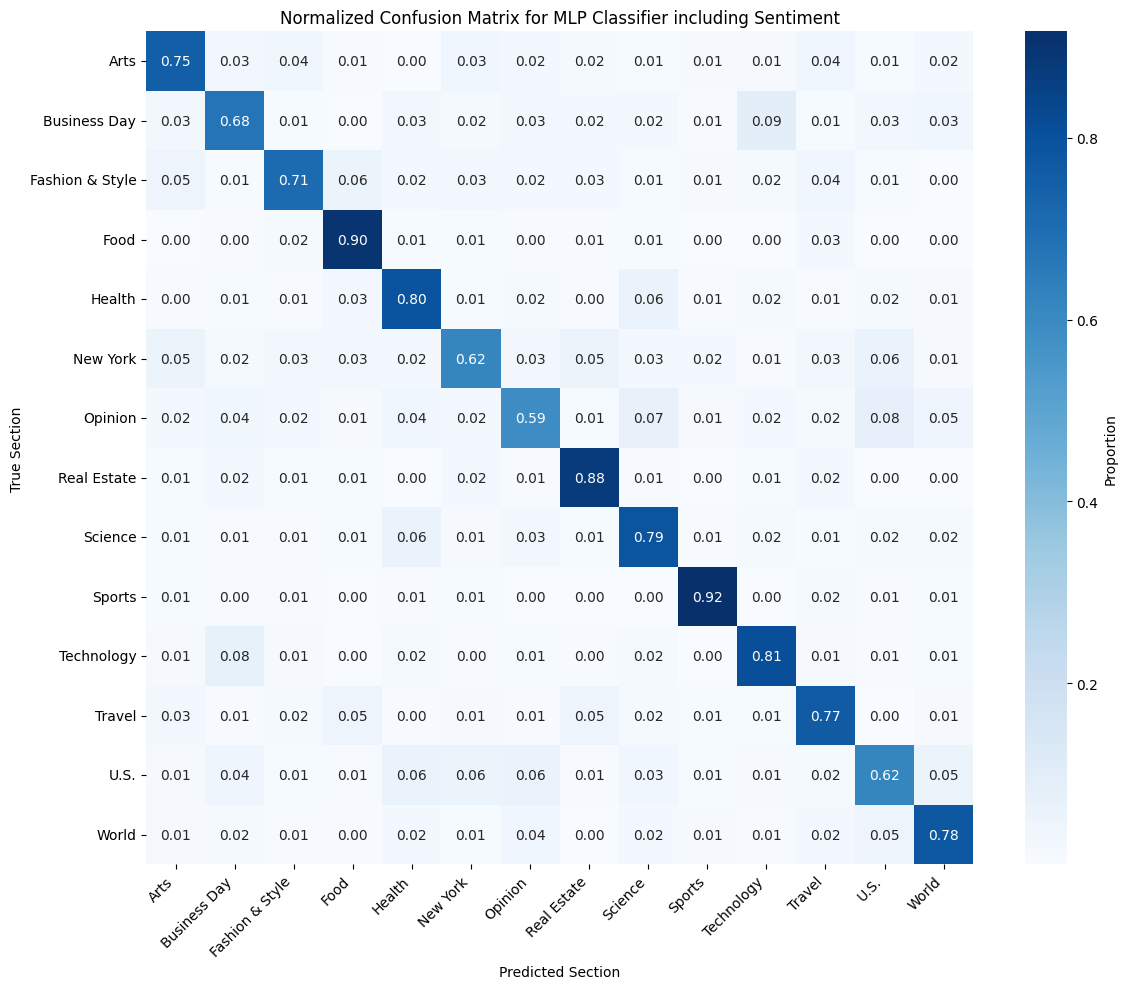

In [29]:
# Collect true & predicted labels on the test set
model_MLPS.eval()
y_true_MLPS, y_pred_MLPS = [], []
with torch.no_grad():
    for Xb, yb in test_loader_MLPS:
        Xb = Xb.to(device)
        logits = model_MLPS(Xb)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        y_pred_MLPS.extend(preds)
        y_true_MLPS.extend(yb.numpy())

y_true_MLPS = np.array(y_true_MLPS)
y_pred_MLPS = np.array(y_pred_MLPS)

# Compute confusion matrix (raw and normalized)
labels = list(range(len(label_encoder.classes_)))  # e.g. [0,1,…,14]
cm     = confusion_matrix(y_true_MLPS, y_pred_MLPS, labels=labels)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

# Visualize normalized confusion matrix
section_names = label_encoder.inverse_transform(labels)

plt.figure(figsize=(12,10))
sns.heatmap(
    cm_norm,
    xticklabels=section_names,
    yticklabels=section_names,
    cmap="Blues",
    annot=True,
    fmt=".2f",
    cbar_kws={"label":"Proportion"}
)
plt.xlabel("Predicted Section")
plt.ylabel("True Section")
plt.title("Normalized Confusion Matrix for MLP Classifier including Sentiment")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()